In [446]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
import seaborn as sns
sns.set()
sns.set(rc={'figure.figsize':(11, 4)})

from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from statistics import mean, stdev


## Load data

In [447]:
samples = pd.read_csv("data/raw/dataset_mood_smartphone.csv", 
                      sep=',', 
                      index_col=0, 
                      parse_dates=["time"],
                      dtype={"id": "category", "variable": "category"})
samples = samples.rename(columns={"time": "datetime"})
samples

,id,datetime,variable,value
1,AS14.01,2014-02-26 13:00:00.000,mood,6.000
2,AS14.01,2014-02-26 15:00:00.000,mood,6.000
3,AS14.01,2014-02-26 18:00:00.000,mood,6.000
4,AS14.01,2014-02-26 21:00:00.000,mood,7.000
5,AS14.01,2014-02-27 09:00:00.000,mood,6.000
...,...,...,...,...
2770399,AS14.30,2014-04-11 07:51:16.948,appCat.weather,8.032
2772465,AS14.30,2014-04-19 11:00:32.747,appCat.weather,3.008
2774026,AS14.30,2014-04-26 10:19:07.434,appCat.weather,7.026
2774133,AS14.30,2014-04-27 00:44:48.450,appCat.weather,23.033


## Remove duplicates

In [448]:
dupes = samples.duplicated(subset=['datetime', 'variable', 'id'], keep='last')
samples_deduped = samples[dupes == False]

## Remove negative values for appCat.* variables

In [449]:
samples_cleaned = samples_deduped[(~(samples_deduped['variable'].str.startswith('app'))) |
                                   ((samples_deduped['variable'].str.startswith('app')) & 
                                   (samples_deduped['value'] > 0))]
samples_cleaned

,id,datetime,variable,value
1,AS14.01,2014-02-26 13:00:00.000,mood,6.000
2,AS14.01,2014-02-26 15:00:00.000,mood,6.000
3,AS14.01,2014-02-26 18:00:00.000,mood,6.000
4,AS14.01,2014-02-26 21:00:00.000,mood,7.000
5,AS14.01,2014-02-27 09:00:00.000,mood,6.000
...,...,...,...,...
2770399,AS14.30,2014-04-11 07:51:16.948,appCat.weather,8.032
2772465,AS14.30,2014-04-19 11:00:32.747,appCat.weather,3.008
2774026,AS14.30,2014-04-26 10:19:07.434,appCat.weather,7.026
2774133,AS14.30,2014-04-27 00:44:48.450,appCat.weather,23.033


## Remove outliers

In [450]:
## Todo

## Pivot the data to a time indexed data frame 
https://pandas.pydata.org/docs/user_guide/reshaping.html

In [451]:
vdata = samples_cleaned.pivot(index="datetime", columns=["id", "variable"], values="value")
vdata

id,AS14.01,AS14.02,AS14.03,AS14.05,AS14.06,AS14.07,AS14.08,AS14.09,AS14.12,AS14.13,...,AS14.06,AS14.09,AS14.12,AS14.16,AS14.25,AS14.26,AS14.27,AS14.28,AS14.30,AS14.32
variable,mood,mood,mood,mood,mood,mood,mood,mood,mood,mood,...,appCat.weather,appCat.weather,appCat.weather,appCat.weather,appCat.weather,appCat.weather,appCat.weather,appCat.weather,appCat.weather,appCat.weather
datetime,,,,,,,,,,,,,,,,,,,,,
2014-02-17 07:00:52.197,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-02-17 07:12:13.631,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-02-17 07:49:19.635,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-02-17 08:57:16.313,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-02-17 08:58:58.471,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-06-08 11:03:34.453,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-06-08 11:04:20.233,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Make features
More feature ideas: 
- weekday vs. weekend day
- day of the week
- recent values from patient-reported data
- relevant app usage data
- use weighted window for aggregated features from the past days

To do feature engineering:
- missing mood values: either
   - remove timespans with no mood data: keep only the longest continuous timespan with mood data
   - only remove outside timespans with no mood data, and *backfill* (NOT *interpolate*) inside (seems reasonable for most patient, except maybe the last two)

To do data cleaning:
- discard outliers

To do train:
- retrain on whole train partition after CV

In [540]:
ids = list(samples["id"].unique())
positive_mood_threshold = 7
longest_allowed_gap = 2

d = {}
for id in ids:
    d[(id, "mood_1D")] = vdata.loc[:, (id , 'mood')].resample('D').mean()
    d[(id, "mood_1D_ffilled")] = vdata.loc[:, (id , 'mood')].resample('D').mean().fillna(method='ffill', limit=longest_allowed_gap)
    d[(id, "valence_1D")] = vdata.loc[:, (id , 'circumplex.valence')].resample('D').mean()
    d[(id, "arousal_1D")] = vdata.loc[:, (id , 'circumplex.arousal')].resample('D').mean()
    d[(id, "social_1D")] = vdata.loc[:, (id , 'appCat.social')].resample('D').sum()
    d[(id, "social_rolling_5D")] = vdata.loc[:, (id , 'appCat.social')].rolling('5D').sum().resample('D').mean() / 5
    d[(id, "social_rolling_10D")] = vdata.loc[:, (id , 'appCat.social')].rolling('10D').sum().resample('D').mean() / 10
    
    mood = vdata.loc[:, (id, 'mood')]
    mood.dropna(inplace=True)
    d[(id, 'mood_first')] = mood.resample('D').first()
    d[(id, 'mood_last')] = mood.resample('D').last()
    d[(id, 'mood_delta')] = features.loc[:, (id, 'mood_last')] - features.loc[:, (id, 'mood_first')]
    
    #d[(id, "target")] = vdata.loc[:, (id , 'mood')].resample('D').mean().shift(-1)
    d[(id, "target")] = d[(id, "mood_1D_ffilled")].shift(-1)
    # converting to int just so we can plot it
    d[(id, "target_binary")] = (d[(id, "target")] >= positive_mood_threshold).astype(int)
    
features = pd.DataFrame(d)
features

AS14.01                                                  \
           mood_1D mood_1D_ffilled valence_1D arousal_1D social_1D   
datetime                                                             
2014-02-17     NaN             NaN        NaN        NaN       0.0   
2014-02-18     NaN             NaN        NaN        NaN       0.0   
2014-02-19     NaN             NaN        NaN        NaN       0.0   
2014-02-20     NaN             NaN        NaN        NaN       0.0   
2014-02-21     NaN             NaN        NaN        NaN       0.0   
...            ...             ...        ...        ...       ...   
2014-06-05     NaN             NaN        NaN        NaN       0.0   
2014-06-06     NaN             NaN        NaN        NaN       0.0   
2014-06-07     NaN             NaN        NaN        NaN       0.0   
2014-06-08     NaN             NaN        NaN        NaN       0.0   
2014-06-09     NaN             NaN        NaN        NaN       0.0   

                                                                      \
           social_rolling_5D social_rolling_10D mood_first mood_last   
datetime                                                               
2014-02-17               NaN                NaN        NaN       NaN   
2014-02-18               NaN                NaN        NaN       NaN   
2014-02-19               NaN                NaN        NaN       NaN   
2014-02-20               NaN                NaN        NaN       NaN   
2014-02-21               NaN                NaN        NaN       NaN   
...                      ...                ...        ...       ...   
2014-06-05               NaN                NaN        NaN       NaN   
2014-06-06               NaN                NaN        NaN       NaN   
2014-06-07               NaN                NaN        NaN       NaN   
2014-06-08               NaN                NaN        NaN       NaN   
2014-06-09               NaN                NaN        NaN       NaN   

                       ...    AS14.33                                         \
           mood_delta  ... valence_1D arousal_1D social_1D social_rolling_5D   
datetime               ...                                                     
2014-02-17        NaN  ...        NaN        NaN       0.0               NaN   
2014-02-18        NaN  ...        NaN        NaN       0.0               NaN   
2014-02-19        NaN  ...        NaN        NaN       0.0               NaN   
2014-02-20        NaN  ...        NaN        NaN       0.0               NaN   
2014-02-21        NaN  ...        NaN        NaN       0.0               NaN   
...               ...  ...        ...        ...       ...               ...   
2014-06-05        NaN  ...        NaN        NaN       0.0               NaN   
2014-06-06        NaN  ...        NaN        NaN       0.0               NaN   
2014-06-07        NaN  ...        NaN        NaN       0.0               NaN   
2014-06-08        NaN  ...        NaN        NaN       0.0               NaN   
2014-06-09        NaN  ...        NaN        NaN       0.0               NaN   

                                                                      \
           social_rolling_10D mood_first mood_last mood_delta target   
datetime                                                               
2014-02-17                NaN        NaN       NaN        NaN    NaN   
2014-02-18                NaN        NaN       NaN        NaN    NaN   
2014-02-19                NaN        NaN       NaN        NaN    NaN   
2014-02-20                NaN        NaN       NaN        NaN    NaN   
2014-02-21                NaN        NaN       NaN        NaN    NaN   
...                       ...        ...       ...        ...    ...   
2014-06-05        1497.527814        NaN       NaN        NaN    NaN   
2014-06-06        1135.224557        NaN       NaN        NaN    NaN   
2014-06-07         885.347048        NaN       NaN        NaN    NaN   
2014-06-08         425.951245       

In [522]:
features.index

DatetimeIndex(['2014-02-17', '2014-02-18', '2014-02-19', '2014-02-20',
               '2014-02-21', '2014-02-22', '2014-02-23', '2014-02-24',
               '2014-02-25', '2014-02-26',
               ...
               '2014-05-31', '2014-06-01', '2014-06-02', '2014-06-03',
               '2014-06-04', '2014-06-05', '2014-06-06', '2014-06-07',
               '2014-06-08', '2014-06-09'],
              dtype='datetime64[ns]', name='datetime', length=113, freq='D')

In [523]:
features.columns.tolist()

[('AS14.01', 'mood_1D'),
 ('AS14.01', 'mood_1D_ffilled'),
 ('AS14.01', 'valence_1D'),
 ('AS14.01', 'arousal_1D'),
 ('AS14.01', 'social_1D'),
 ('AS14.01', 'social_rolling_5D'),
 ('AS14.01', 'social_rolling_10D'),
 ('AS14.01', 'mood_first'),
 ('AS14.01', 'mood_last'),
 ('AS14.01', 'mood_delta'),
 ('AS14.01', 'target'),
 ('AS14.01', 'target_binary'),
 ('AS14.02', 'mood_1D'),
 ('AS14.02', 'mood_1D_ffilled'),
 ('AS14.02', 'valence_1D'),
 ('AS14.02', 'arousal_1D'),
 ('AS14.02', 'social_1D'),
 ('AS14.02', 'social_rolling_5D'),
 ('AS14.02', 'social_rolling_10D'),
 ('AS14.02', 'mood_first'),
 ('AS14.02', 'mood_last'),
 ('AS14.02', 'mood_delta'),
 ('AS14.02', 'target'),
 ('AS14.02', 'target_binary'),
 ('AS14.03', 'mood_1D'),
 ('AS14.03', 'mood_1D_ffilled'),
 ('AS14.03', 'valence_1D'),
 ('AS14.03', 'arousal_1D'),
 ('AS14.03', 'social_1D'),
 ('AS14.03', 'social_rolling_5D'),
 ('AS14.03', 'social_rolling_10D'),
 ('AS14.03', 'mood_first'),
 ('AS14.03', 'mood_last'),
 ('AS14.03', 'mood_delta'),
 ('AS

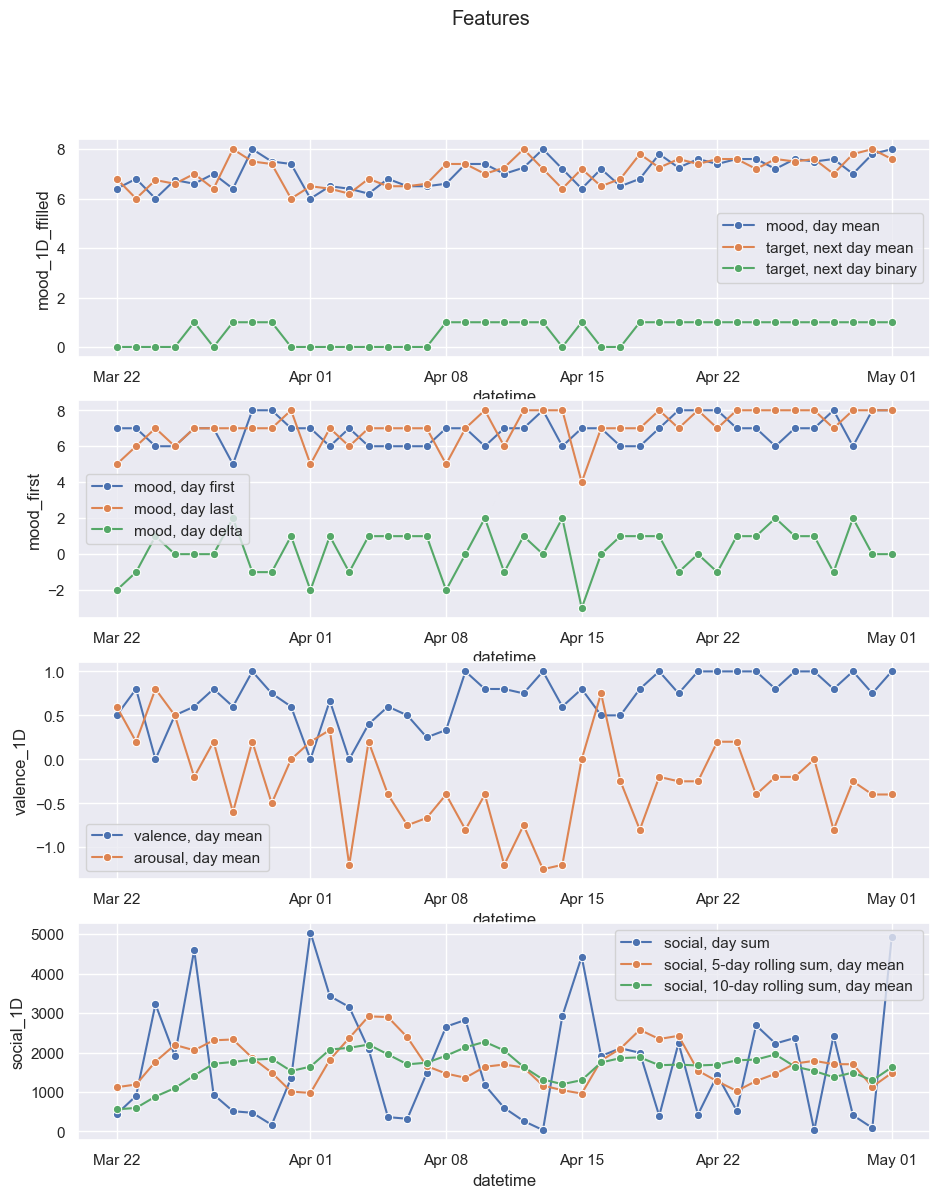

In [525]:
id = 'AS14.01'
start, end = '2014-03-22', '2014-05-01'
data = features[id]

fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(11, 13))
for ax in axs:
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
fig.suptitle('Features')

sns.lineplot(ax=axs[0], data=data['mood_1D_ffilled'].loc[start:end], label='mood, day mean', marker='o')
sns.lineplot(ax=axs[0], data=data['target'].loc[start:end], label='target, next day mean', marker='o')
sns.lineplot(ax=axs[0], data=data['target_binary'].loc[start:end], label='target, next day binary', marker='o')

sns.lineplot(ax=axs[1], data=data['mood_first'].loc[start:end], label='mood, day first', marker='o')
sns.lineplot(ax=axs[1], data=data['mood_last'].loc[start:end], label='mood, day last', marker='o')
sns.lineplot(ax=axs[1], data=data['mood_delta'].loc[start:end], label='mood, day delta', marker='o')

sns.lineplot(ax=axs[2], data=data['valence_1D'].loc[start:end], label='valence, day mean', marker='o')
sns.lineplot(ax=axs[2], data=data['arousal_1D'].loc[start:end], label='arousal, day mean', marker='o')

sns.lineplot(ax=axs[3], data=data['social_1D'].loc[start:end], marker='o', label='social, day sum')
sns.lineplot(ax=axs[3], data=data['social_rolling_5D'].loc[start:end], marker='o', label='social, 5-day rolling sum, day mean ');
sns.lineplot(ax=axs[3], data=data['social_rolling_10D'].loc[start:end], marker='o', label='social, 10-day rolling sum, day mean ');


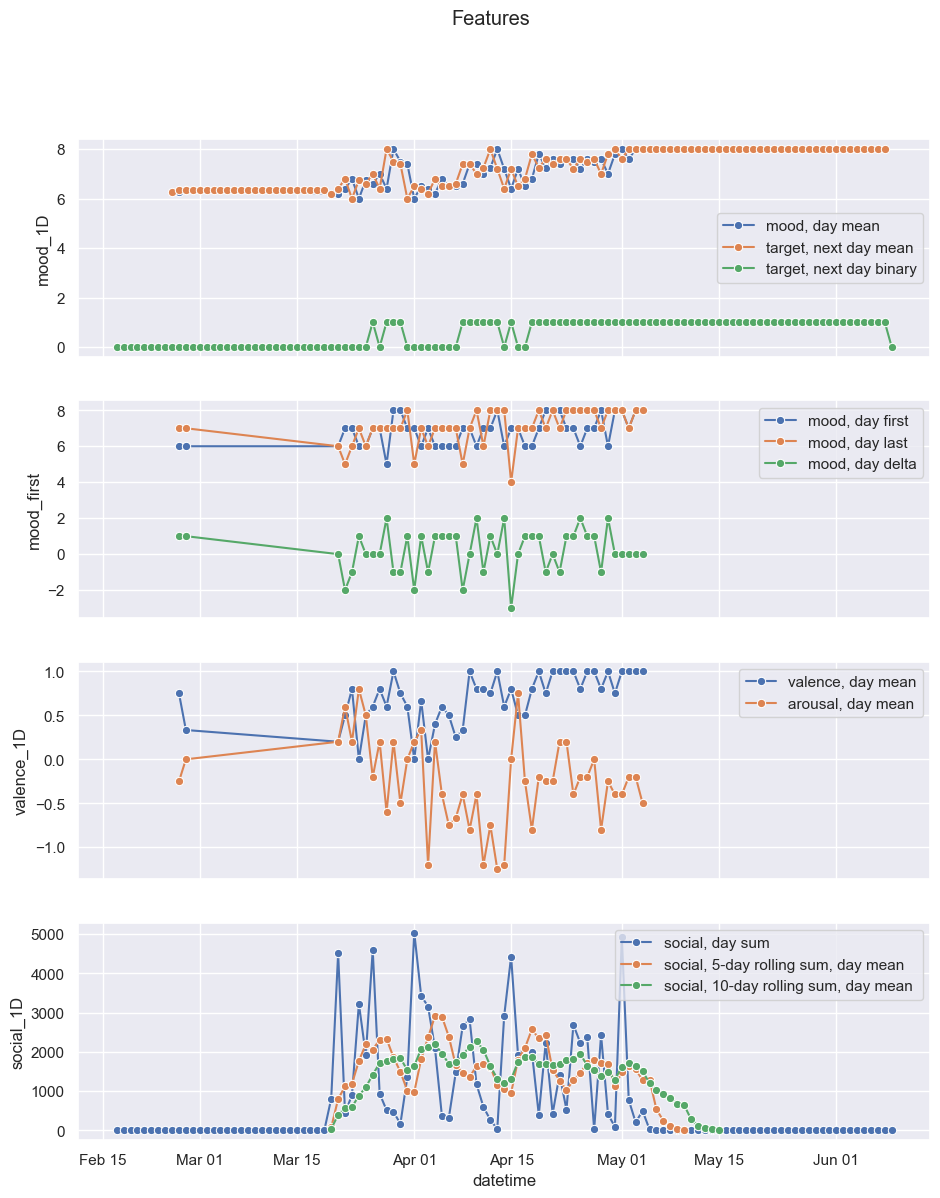

In [502]:
id = 'AS14.01'
data = features[id]

fig, axs = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(11, 13))
for ax in axs:
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
fig.suptitle('Features')

sns.lineplot(ax=axs[0], data=data['mood_1D'], label='mood, day mean', marker='o')
sns.lineplot(ax=axs[0], data=data['target'], label='target, next day mean', marker='o')
sns.lineplot(ax=axs[0], data=data['target_binary'], label='target, next day binary', marker='o')

sns.lineplot(ax=axs[1], data=data['mood_first'], label='mood, day first', marker='o')
sns.lineplot(ax=axs[1], data=data['mood_last'], label='mood, day last', marker='o')
sns.lineplot(ax=axs[1], data=data['mood_delta'], label='mood, day delta', marker='o')

sns.lineplot(ax=axs[2], data=data['valence_1D'], label='valence, day mean', marker='o')
sns.lineplot(ax=axs[2], data=data['arousal_1D'], label='arousal, day mean', marker='o')

sns.lineplot(ax=axs[3], data=data['social_1D'], marker='o', label='social, day sum')
sns.lineplot(ax=axs[3], data=data['social_rolling_5D'], marker='o', label='social, 5-day rolling sum, day mean ');
sns.lineplot(ax=axs[3], data=data['social_rolling_10D'], marker='o', label='social, 10-day rolling sum, day mean ');


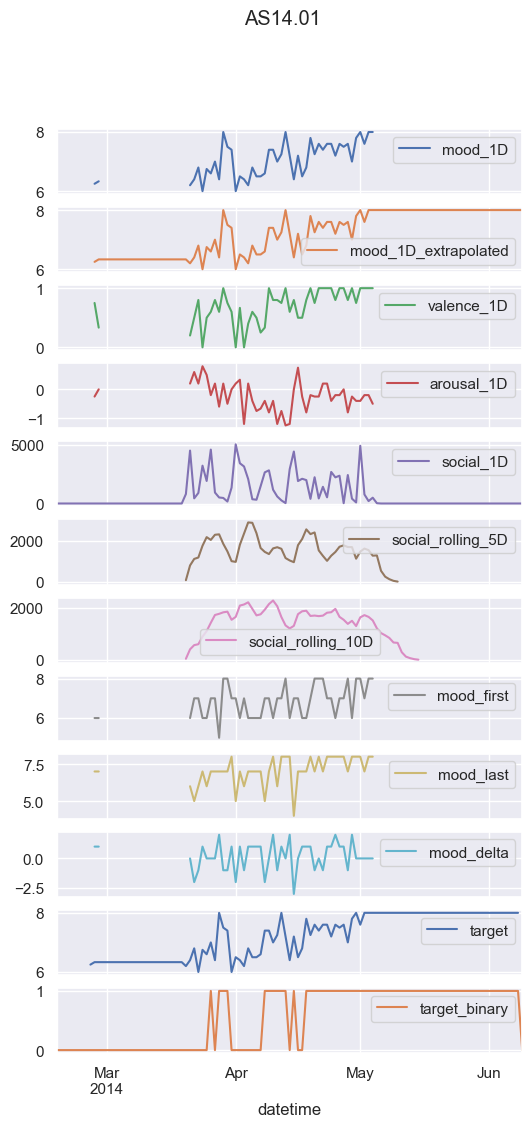

In [503]:
data.plot(subplots=True, figsize=(6, 12), title=id);

## Train and evaluate

### Toy: decision trees for patient AS14.01

In [ ]:
id = 'AS14.01'

# To do:
# use pir() from explore-flo.ipynb to convert the mood data a continuous stretch
# drop everything before and after
# align y target to resulting x series
x = features[id][['mood_1D', 'valence_1D']].dropna()
y = features[id]['target_binary']
y = y.reindex_like(x)

sns.lineplot(x, marker='o')
sns.lineplot(y, marker='o', color='lightgreen')

# Preprocess labels
le = LabelEncoder()
le.fit(y)
y = le.transform(y)
 
# Decision tree
clf = DecisionTreeClassifier()
scores = cross_val_score(clf, x, y, cv=5)
print(scores)
print(f"CV: {scores.mean():0.2f} accuracy with a standard deviation of {scores.std():0.2f}\n")

# Roll-your-own cross validation
accuracy = { 'train': [], 'test': [] }
for i in range(10):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

    clf.fit(x_train, y_train)

    y_train_predicted = clf.predict(x_train)
    accuracy['train'].append(accuracy_score(y_train, y_train_predicted))

    y_test_predicted = clf.predict(x_test)
    accuracy['test'].append(accuracy_score(y_test, y_test_predicted))


print(f"accuracy train = {accuracy['train']}")
print(f"accuracy test  = {accuracy['test']}\n")

print(f"{mean(accuracy['train']):0.2f} accuracy with a standard deviation of {stdev(accuracy['train']):0.2f}") 
print(f"{mean(accuracy['test']):0.2f} accuracy with a standard deviation of {stdev(accuracy['test']):0.2f}" )


## Below cells are just a scratchpad, don't use

In [528]:
#id = 'AS14.32'
id = 'AS14.01'

In [530]:
x = features[id][['mood_1D', 'valence_1D']]
x

,mood_1D,valence_1D
datetime,,
2014-02-17,NaN,NaN
2014-02-18,NaN,NaN
2014-02-19,NaN,NaN
2014-02-20,NaN,NaN
2014-02-21,NaN,NaN
...,...,...
2014-06-05,NaN,NaN
2014-06-06,NaN,NaN
2014-06-07,NaN,NaN


In [531]:
len(x)

113

In [532]:
y = features[id]['target_binary']

In [533]:
len(x), len(y), type(x), type(y)

(113, 113, pandas.core.frame.DataFrame, pandas.core.series.Series)

In [534]:
x.index

DatetimeIndex(['2014-02-17', '2014-02-18', '2014-02-19', '2014-02-20',
               '2014-02-21', '2014-02-22', '2014-02-23', '2014-02-24',
               '2014-02-25', '2014-02-26',
               ...
               '2014-05-31', '2014-06-01', '2014-06-02', '2014-06-03',
               '2014-06-04', '2014-06-05', '2014-06-06', '2014-06-07',
               '2014-06-08', '2014-06-09'],
              dtype='datetime64[ns]', name='datetime', length=113, freq='D')

In [535]:
y = y.reindex_like(x)
y

datetime
2014-02-17    0
2014-02-18    0
2014-02-19    0
2014-02-20    0
2014-02-21    0
             ..
2014-06-05    1
2014-06-06    1
2014-06-07    1
2014-06-08    1
2014-06-09    0
Freq: D, Name: target_binary, Length: 113, dtype: int64

In [536]:
len(x), len(y)

(113, 113)

<Axes: xlabel='datetime', ylabel='target_binary'>

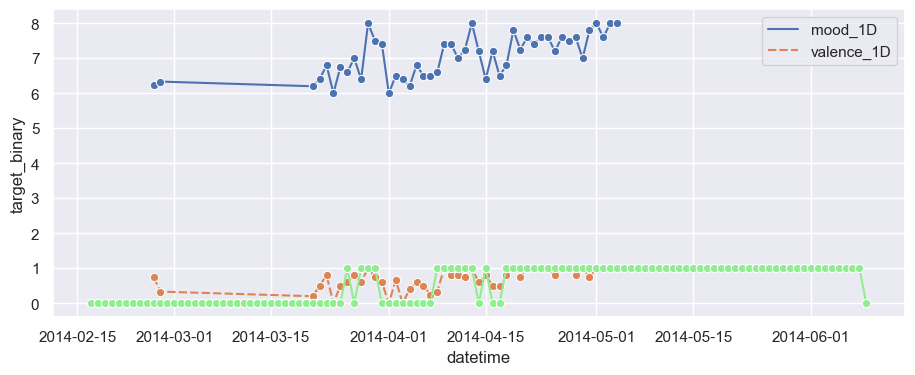

In [537]:
sns.lineplot(x, marker='o')
sns.lineplot(y, marker='o', color='lightgreen')

In [538]:
le = LabelEncoder()
le.fit(y)
y = le.transform(y)

y

In [539]:
# Decision tree
clf = DecisionTreeClassifier()
scores = cross_val_score(clf, x, y, cv=5)
print(scores)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/adele/miniconda3/envs/torch/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/adele/miniconda3/envs/torch/lib/python3.9/site-packages/sklearn/tree/_classes.py", line 889, in fit
    super().fit(
  File "/Users/adele/miniconda3/envs/torch/lib/python3.9/site-packages/sklearn/tree/_classes.py", line 186, in fit
    X, y = self._validate_data(
  File "/Users/adele/miniconda3/envs/torch/lib/python3.9/site-packages/sklearn/base.py", line 579, in _validate_data
    X = check_array(X, input_name="X", **check_X_params)
  File "/Users/adele/miniconda3/envs/torch/lib/python3.9/site-packages/sklearn/utils/validation.py", line 921, in check_array
    _assert_all_finite(
  File "/Users/adele/miniconda3/envs/torch/lib/python3.9/site-packages/sklearn/utils/validation.py", line 161, in _assert_all_finite
    raise ValueError(msg_err)
ValueError: Input X contains NaN.
DecisionTreeClassifier does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values


In [516]:
x_train, x_test, y_train, y_test = x.iloc[:36], x.iloc[36:], y[:36], y[36:]
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)
clf.fit(x_train, y_train)

y_train_predicted = clf.predict(x_train)
accuracy_train = accuracy_score(y_train, y_train_predicted)

y_test_predicted = clf.predict(x_test)
accuracy_test = accuracy_score(y_test, y_test_predicted)


print(f"accuracy_train = {accuracy_train:0.2f}")
print(f"accuracy_test  = {accuracy_test:0.2f}")

(36, 2) (9, 2) (36,) (9,)
accuracy_train = 0.94
accuracy_test  = 0.89


In [517]:
accuracy = { 'train': [], 'test': [] }
for i in range(10):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

    clf.fit(x_train, y_train)

    y_train_predicted = clf.predict(x_train)
    accuracy['train'].append(accuracy_score(y_train, y_train_predicted))

    y_test_predicted = clf.predict(x_test)
    accuracy['test'].append(accuracy_score(y_test, y_test_predicted))


# print(f"accuracy train = {accuracy['train']}")
# print(f"accuracy test  = {accuracy['test']}")

print(f"{mean(accuracy['train']):0.2f} accuracy with a standard deviation of {stdev(accuracy['train']):0.2f}") 
print(f"{mean(accuracy['test']):0.2f} accuracy with a standard deviation of {stdev(accuracy['test']):0.2f}" )


0.97 accuracy with a standard deviation of 0.02
0.73 accuracy with a standard deviation of 0.16


array([<Axes: xlabel='datetime'>, <Axes: xlabel='datetime'>,
       <Axes: xlabel='datetime'>], dtype=object)

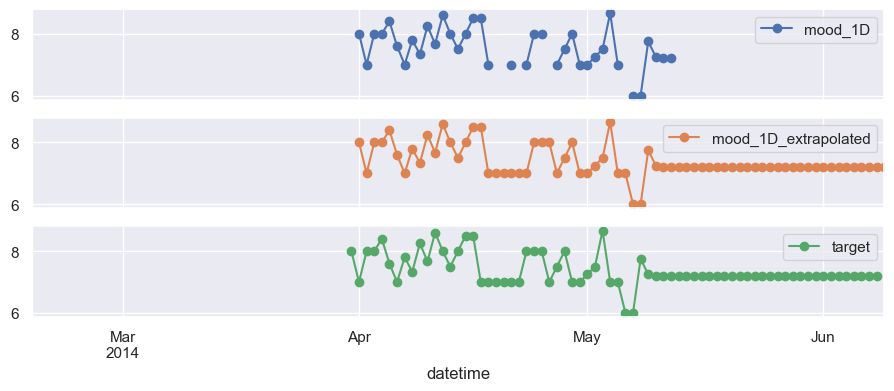

In [518]:
m = features['AS14.32'][['mood_1D', 'mood_1D_extrapolated', 'target']]
m.plot(subplots=True, marker='o')